#Identitas Anggota Kelompok :
- Samuel Steve Mulyono - 5025231197
- Naswan Nashir Ramadhan - 5025231246
- Valensio Arvin Putra Setiawan - 5025231273

In [ ]:
!unzip dataset-resized.zip -d dataset-resized

Archive:  dataset-resized.zip
   creating: dataset-resized/dataset-resized/
  inflating: dataset-resized/dataset-resized/.DS_Store  
   creating: dataset-resized/__MACOSX/
   creating: dataset-resized/__MACOSX/dataset-resized/
  inflating: dataset-resized/__MACOSX/dataset-resized/._.DS_Store  
   creating: dataset-resized/dataset-resized/cardboard/
  inflating: dataset-resized/dataset-resized/cardboard/cardboard1.jpg  
  inflating: dataset-resized/dataset-resized/cardboard/cardboard10.jpg  
  inflating: dataset-resized/dataset-resized/cardboard/cardboard100.jpg  
  inflating: dataset-resized/dataset-resized/cardboard/cardboard101.jpg  
  inflating: dataset-resized/dataset-resized/cardboard/cardboard102.jpg  
  inflating: dataset-resized/dataset-resized/cardboard/cardboard103.jpg  
  inflating: dataset-resized/dataset-resized/cardboard/cardboard104.jpg  
  inflating: dataset-resized/dataset-resized/cardboard/cardboard105.jpg  
  inflating: dataset-resized/dataset-resized/cardboard/cardb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os

dataset_path = 'dataset-resized/dataset-resized'
class_counts = {name: len(os.listdir(os.path.join(dataset_path, name))) for name in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, name))}
print("Class distribution:", class_counts)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Class distribution: {'metal': 410, 'glass': 501, 'trash': 137, 'paper': 594, 'cardboard': 403, 'plastic': 482}


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import random
import os

# Set seeds for reproducibility
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Augmentation & generators
def get_data_generators(img_size):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.2
    )

    val_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
    )

    train_gen = train_datagen.flow_from_directory(
        dataset_path,
        target_size=img_size,
        batch_size=32,
        class_mode='categorical',
        subset='training',
        seed=SEED
    )

    val_gen = val_datagen.flow_from_directory(
        dataset_path,
        target_size=img_size,
        batch_size=32,
        class_mode='categorical',
        subset='validation',
        seed=SEED
    )

    return train_gen, val_gen


In [ ]:
def train_model(base_model_fn, model_name, input_shape):
    print(f"\n=== Training {model_name} ===")

    train_gen, val_gen = get_data_generators(input_shape)

    base_model = base_model_fn(weights='imagenet', include_top=False, input_shape=(*input_shape, 3))
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(train_gen.num_classes, activation='softmax')
    ])

    model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train head
    model.fit(train_gen, validation_data=val_gen, epochs=3, callbacks=[early_stop])

    # Fine-tuning
    base_model.trainable = True
    for layer in base_model.layers[:-20]:
        layer.trainable = False

    model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model.fit(train_gen, validation_data=val_gen, epochs=40, callbacks=[early_stop])

    # Save model to Google Drive
    save_path = f'/content/drive/MyDrive/{model_name}.keras'
    model.save(save_path)
    print(f"Model saved to {save_path}")


In [ ]:
from tensorflow.keras.applications import ResNet50, EfficientNetB0, MobileNetV2

train_model(ResNet50,       "resnet50",       input_shape=(224, 224))
train_model(EfficientNetB0, "efficientnetb0", input_shape=(224, 224))
train_model(MobileNetV2,    "mobilenetv2",    input_shape=(224, 224))



=== Training resnet50 ===
Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.1998 - loss: 1.8887

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


64/64 ━━━━━━━━━━━━━━━━━━━━ 55s 627ms/step - accuracy: 0.2001 - loss: 1.8870 - val_accuracy: 0.2346 - val_loss: 1.6790
Epoch 2/3
64/64 ━━━━━━━━━━━━━━━━━━━━ 64s 453ms/step - accuracy: 0.2692 - loss: 1.6881 - val_accuracy: 0.2465 - val_loss: 1.6481
Epoch 3/3
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 448ms/step - accuracy: 0.2513 - loss: 1.6816 - val_accuracy: 0.2386 - val_loss: 1.6513
Epoch 1/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 57s 615ms/step - accuracy: 0.2435 - loss: 2.3690 - val_accuracy: 0.2326 - val_loss: 1.6622
Epoch 2/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 29s 455ms/step - accuracy: 0.2989 - loss: 1.6217 - val_accuracy: 0.2465 - val_loss: 1.6879
Epoch 3/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 28s 434ms/step - accuracy: 0.3314 - loss: 1.5876 - val_accuracy: 0.2525 - val_loss: 1.6944
Epoch 4/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 28s 433ms/step - accuracy: 0.3472 - loss: 1.5561 - val_accuracy: 0.2485 - val_loss: 1.6876
Epoch 5/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 29s 450ms/step - accuracy: 0.3967 - loss: 1.5122 - val_accuracy: 0.2664 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - accuracy: 0.1987 - loss: 1.7860

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


64/64 ━━━━━━━━━━━━━━━━━━━━ 72s 756ms/step - accuracy: 0.1988 - loss: 1.7858 - val_accuracy: 0.1909 - val_loss: 1.7402
Epoch 2/3
64/64 ━━━━━━━━━━━━━━━━━━━━ 27s 414ms/step - accuracy: 0.2162 - loss: 1.7495 - val_accuracy: 0.2346 - val_loss: 1.7266
Epoch 3/3
64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 413ms/step - accuracy: 0.2249 - loss: 1.7282 - val_accuracy: 0.2346 - val_loss: 1.7281
Epoch 1/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 74s 766ms/step - accuracy: 0.1787 - loss: 1.8047 - val_accuracy: 0.2346 - val_loss: 1.7250
Epoch 2/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 27s 419ms/step - accuracy: 0.1862 - loss: 1.7706 - val_accuracy: 0.2346 - val_loss: 1.7246
Epoch 3/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 27s 415ms/step - accuracy: 0.2140 - loss: 1.7541 - val_accuracy: 0.2346 - val_loss: 1.7243
Epoch 4/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 411ms/step - accuracy: 0.2196 - loss: 1.7499 - val_accuracy: 0.2346 - val_loss: 1.7246
Epoch 5/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 27s 415ms/step - accuracy: 0.2177 - loss: 1.7408 - val_accuracy: 0.2346 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.4982 - loss: 1.4049

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


64/64 ━━━━━━━━━━━━━━━━━━━━ 43s 532ms/step - accuracy: 0.4998 - loss: 1.4002 - val_accuracy: 0.6938 - val_loss: 0.7332
Epoch 2/3
64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 406ms/step - accuracy: 0.7358 - loss: 0.6889 - val_accuracy: 0.7237 - val_loss: 0.6439
Epoch 3/3
64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 406ms/step - accuracy: 0.7745 - loss: 0.6362 - val_accuracy: 0.7475 - val_loss: 0.6274
Epoch 1/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 49s 561ms/step - accuracy: 0.5942 - loss: 1.1256 - val_accuracy: 0.7435 - val_loss: 0.6254
Epoch 2/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 410ms/step - accuracy: 0.7395 - loss: 0.7602 - val_accuracy: 0.7515 - val_loss: 0.6206
Epoch 3/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 27s 417ms/step - accuracy: 0.7552 - loss: 0.6755 - val_accuracy: 0.7614 - val_loss: 0.6162
Epoch 4/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 414ms/step - accuracy: 0.7979 - loss: 0.5888 - val_accuracy: 0.7575 - val_loss: 0.6122
Epoch 5/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 411ms/step - accuracy: 0.8052 - loss: 0.5486 - val_accuracy: 0.7555 

In [ ]:
# Import required libraries
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')
# Define class names (adjust if different in your dataset)
class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

# Load models
model_1 = tf.keras.models.load_model('/content/drive/MyDrive/mobilenetv2.keras')
model_2 = tf.keras.models.load_model('/content/drive/MyDrive/efficientnetb0.keras')
model_3 = tf.keras.models.load_model('/content/drive/MyDrive/resnet50.keras')
# Ensemble prediction functio
def ensemble_predict(img_path, models):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Get predictions from all models
    predictions = [model.predict(img_array) for model in models]
    for i, model in enumerate(models):
        pred = model.predict(img_array)
        predicted_class = class_names[np.argmax(pred)]
        confidence = np.max(pred) * 100
        print(f"Model {i+1} Prediction: {predicted_class} ({confidence:.2f}%)")
        predictions.append(pred)

    avg_predictions = np.mean(predictions, axis=0)
    final_class = class_names[np.argmax(avg_predictions)]
    final_confidence = np.max(avg_predictions) * 100
    return final_class, final_confidence

# Test ensemble
uploaded = files.upload()
for img_name in uploaded.keys():
    predicted_class, confidence = ensemble_predict(img_name, [model_1, model_2, model_3])
    print(f"Image: {img_name}, Predicted: {predicted_class}, Confidence: {confidence:.2f}%")

Mounted at /content/drive


Saving scrap-metal-recycling.jpg to scrap-metal-recycling.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
Model 1 Prediction: metal (89.45%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
Model 2 Prediction: paper (22.93%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Model 3 Prediction: paper (43.61%)
Image: scrap-metal-recycling.jpg, Predicted: metal, Confidence: 47.40%


Found 503 images belonging to 6 classes.


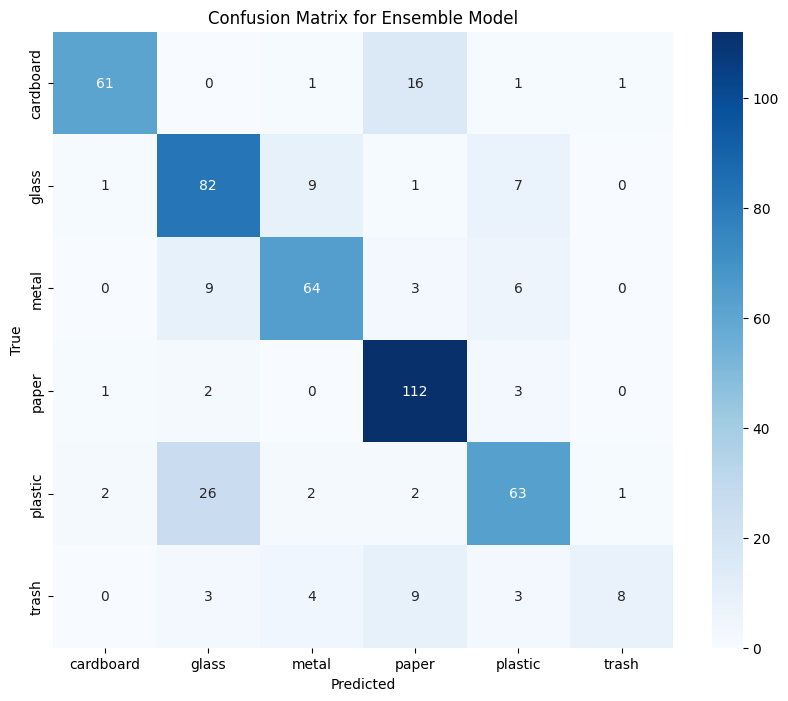


Classification Report:
              precision    recall  f1-score   support

   cardboard       0.94      0.76      0.84        80
       glass       0.67      0.82      0.74       100
       metal       0.80      0.78      0.79        82
       paper       0.78      0.95      0.86       118
     plastic       0.76      0.66      0.70        96
       trash       0.80      0.30      0.43        27

    accuracy                           0.78       503
   macro avg       0.79      0.71      0.73       503
weighted avg       0.78      0.78      0.77       503



In [ ]:
# --- Evaluation: Confusion Matrix and Classification Report ---
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import tempfile

dataset_path = '/content/drive/MyDrive/dataset-resized'
SEED = 42
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
val_generator = val_datagen.flow_from_directory(dataset_path, target_size=(224, 224), batch_size=1, class_mode='categorical', subset='validation', shuffle=False)

predictions = []
true_labels = []
val_generator.reset()
for i in range(len(val_generator)):
    img, label = next(val_generator)
    img_pil = Image.fromarray((img[0] * 255).astype(np.uint8))
    with tempfile.NamedTemporaryFile(suffix='.jpg', delete=False) as tmp_file:
        img_pil.save(tmp_file.name)
        # Suppress print output by redirecting stdout
        import sys
        original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
        pred_class, _ = ensemble_predict(tmp_file.name, [model_1, model_2, model_3])
        sys.stdout = original_stdout
        predictions.append(class_names.index(pred_class))
    true_labels.append(np.argmax(label[0]))
    os.remove(tmp_file.name)

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for Ensemble Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('/content/drive/MyDrive/confusion_matrix.png')
plt.show()
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=class_names))